In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from scipy.stats import norm, gaussian_kde, chi2
from scipy.special import log1p
import os

In [80]:
df = pd.read_csv('output_data/permute_results.csv')
print(df.head())
print(df.shape)

   id patient_id permute_type connection_type       BTP       ATP    ACTP
0   1   UCLH1005           ac              gd  0.000000  0.450000  0.3125
1   2   UCLH1045           ac              gd  0.500000  0.000000  0.7500
2   3   UCLH1045           ac              gd  1.000000  0.500000  0.6250
3   7   UCLH1106           ac              gd  0.666667  0.333333  0.2500
4   8   UCLH1106           ac              gd  1.000000  1.000000  0.7500
(176088, 7)


In [81]:
def calculate_difference(df):
    df['BTP-ATP'] = df['BTP'] - df['ATP']
    df['BTP-ACTP'] = df['BTP'] - df['ACTP']
    df['ATP-ACTP'] = df['ATP'] - df['ACTP']
    return df

In [82]:
df = calculate_difference(df)
print(df.head())

   id patient_id permute_type connection_type       BTP       ATP    ACTP  \
0   1   UCLH1005           ac              gd  0.000000  0.450000  0.3125   
1   2   UCLH1045           ac              gd  0.500000  0.000000  0.7500   
2   3   UCLH1045           ac              gd  1.000000  0.500000  0.6250   
3   7   UCLH1106           ac              gd  0.666667  0.333333  0.2500   
4   8   UCLH1106           ac              gd  1.000000  1.000000  0.7500   

    BTP-ATP  BTP-ACTP  ATP-ACTP  
0 -0.450000 -0.312500  0.137500  
1  0.500000 -0.250000 -0.750000  
2  0.500000  0.375000 -0.125000  
3  0.333333  0.416667  0.083333  
4  0.000000  0.250000  0.250000  


In [83]:
def calculate_p_value(sample, actual):
    # sample = sample[~np.isnan(sample)]
    # if sample.size == 0:
    #     return np.nan
    
    # norm
    # mu, std = norm.fit(sample)
    # p_value = norm.cdf(actual, mu, std)
    
    # kde
    # kde = gaussian_kde(sample)
    # p_value = kde.integrate_box_1d(-np.inf, actual)

    # new
    p_value = (sum(sample < actual) + sum(sample == actual)/2)/len(sample)

    return p_value

def combine_p_values(p_values_list):
    # epsilon = 1e-10
    epsilon = 1/(1000 * 2)
    p_values_list = np.array(p_values_list)
    count0 = len(p_values_list) - np.count_nonzero(p_values_list)
    p_values_list[p_values_list == 0] = epsilon

    chi_squared_stat = -2 * np.sum(np.log(p_values_list))
    combined_p_value = chi2.sf(chi_squared_stat, 2 * len(p_values_list))
    return combined_p_value, count0

In [84]:
def show_density_subplot(df, show_figure, id):
    show_figure_list = show_figure.split('_')
    permute_type = show_figure_list[0]
    connection_type = show_figure_list[1]
    figure_type = show_figure_list[2]
    df_permute = df[(df['permute_type'] == permute_type) & (df['connection_type'] == connection_type) & (df['id'] == id)] 
    df_permute = df_permute[figure_type]
    df_actual = df[(df['permute_type'] == 'ac') & (df['connection_type'] == connection_type) & (df['id'] == id)]
    patient_id = df_actual['patient_id'].values[0]
    df_actual = df_actual[figure_type].values[0]
    p_value = calculate_p_value(df_permute, df_actual)

    # sns.kdeplot(df_permute, fill=False)
    color_dict = {'BTP':'#6e6a91', 'ATP':'#ca8bb5', 'ACTP':'#f6ca67'}
    ax = sns.histplot(data=df_permute, bins=10, kde=True, binrange=[0, 1], 
                 color=color_dict[figure_type],
                 alpha=0.8,
                 line_kws={'color': 'k', 'linewidth': 1},
                 edgecolor='white')
    if len(set(df_permute)) != 1:
        ax.lines[0].set_color('k')
    
    plt.axvline(x=df_permute.mean(), color='blue', linewidth = 1)
    if df_permute.mean()<0.7:
        plt.text(df_permute.mean()+0.02, 550, f'avg = {df_permute.mean():.2f}', color='blue', ha='left')
    else:
        plt.text(df_permute.mean()-0.02, 550, f'avg = {df_permute.mean():.2f}', color='blue', ha='right')

    plt.axvline(x=df_actual, color='#c1272d', linestyle='--', linewidth = 1)
    if df_actual<0.7:
        plt.text(df_actual+0.02, 280, f'actual = {df_actual:.2f}\np={p_value}', color='#c1272d', ha='left')
    else:
        plt.text(df_actual-0.02, 280, f'actual = {df_actual:.2f}\np={p_value}', color='#c1272d', ha='right')
    
    plt.text(0.02, 720, f'Seizure {id}\n{patient_id}', color='k', ha='left', fontweight='bold')
    # sns.rugplot(data=df_permute, height=.1)
    dict1 = {'gd':'Graph Density', 'lcc':'Largest CC Density', 'pr':'Permute Regions', 'pt':'Permute TPs',
              'BTP':'Regions Before TP', 'ATP':'Regions After TP', 'ACTP':'Regions Across TP'}
    plt.title(f'{dict1[connection_type]} of {dict1[figure_type]}\n Using {dict1[permute_type]} Method', fontsize=11)
    plt.xlim([0, 1])
    plt.ylim([0, 1000])
    plt.yticks([i for i in range(0, 1001, 250)])
    plt.xlabel("")
    plt.ylabel("")

['pr_gd_BTP', 'pr_gd_ATP', 'pr_gd_ACTP', 'pr_lcc_BTP', 'pr_lcc_ATP', 'pr_lcc_ACTP', 'pt_gd_BTP', 'pt_gd_ATP', 'pt_gd_ACTP', 'pt_lcc_BTP', 'pt_lcc_ATP', 'pt_lcc_ACTP']


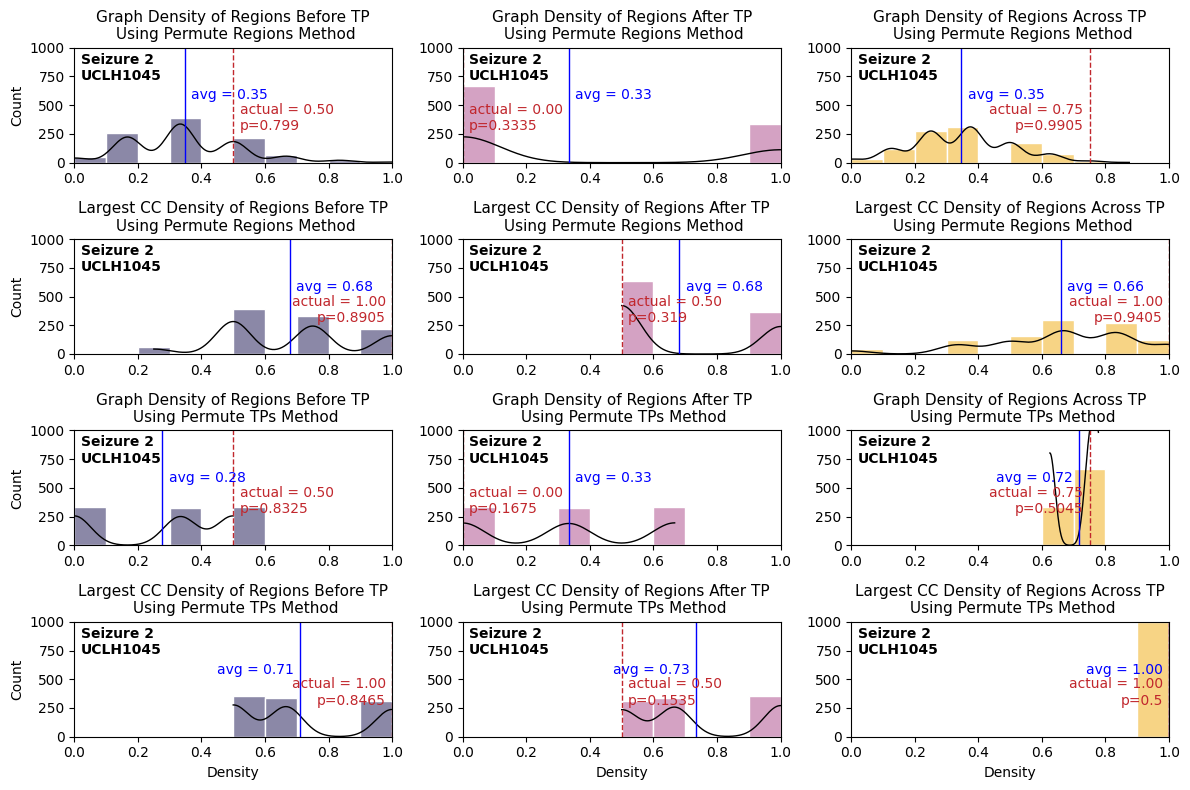

In [85]:
id = 2

list1 = ['pr', 'pt']
list2 = ['gd', 'lcc']
list3 = ['BTP', 'ATP', 'ACTP']
combinations = itertools.product(list1, list2, list3)
category_list = ['_'.join(combination) for combination in combinations]

print(category_list)
plt.figure(figsize=(12, 8))
axes = []
for i, category in enumerate(category_list):
    ax = plt.subplot(4, 3, i+1)
    axes.append(ax)
    show_density_subplot(df, category, id)

axes[0].set_ylabel('Count')
axes[3].set_ylabel('Count')
axes[6].set_ylabel('Count')
axes[9].set_ylabel('Count')
axes[9].set_xlabel('Density')
axes[10].set_xlabel('Density')
axes[11].set_xlabel('Density')

plt.tight_layout()

plt.savefig(f'figures/seizure{id}_density.png', dpi=300)
plt.savefig(f'figures/seizure{id}_density.svg')

plt.show()

In [86]:
def save_density_p_values(df):
    sample_size = set(df['id'])
    patient_size = set(df['patient_id'])
    print(f'{len(sample_size)} samples form {len(patient_size)} patients.')

    list1 = ['pr', 'pt']
    list2 = ['gd', 'lcc']
    list3 = ['BTP', 'ATP', 'ACTP']

    data = []
    
    for id in sample_size:
        for permute_type in list1:
            for connection_type in list2:
                df1 = df[(df['permute_type'] == permute_type) & (df['connection_type'] == connection_type) & (df['id'] == id)]
                df2 = df[(df['permute_type'] == 'ac') & (df['connection_type'] == connection_type) & (df['id'] == id)]
                regions_result = []
                for region_type in list3:
                    sample = df1[region_type]
                    actual = df2[region_type].values[0]
                    p_value = calculate_p_value(sample, actual)
                    regions_result.append(p_value)
                patient = df2['patient_id'].values[0]
                row = {
                    'id' : id,
                    'patient_id' : patient,
                    'permute_type' : permute_type, 
                    'connection_type' : connection_type, 
                    'BTP' : regions_result[0], 
                    'ATP' : regions_result[1], 
                    'ACTP' : regions_result[2]
                }
                data.append(row)

    p_value_result = pd.DataFrame(data, columns=['id', 'patient_id', 'permute_type', 'connection_type', 'BTP', 'ATP', 'ACTP'])

    return p_value_result

In [87]:
p_value_df = save_density_p_values(df)
print(p_value_df.head())
print(p_value_df.shape)

output_path = os.path.join('output_data', 'density_p_value_results.csv')
p_value_df.to_csv(output_path, index=False)
print(f'DataFrame saved to {output_path}')

44 samples form 20 patients.
   id patient_id permute_type connection_type     BTP     ATP    ACTP
0   1   UCLH1005           pr              gd  0.3005  0.8610  0.1500
1   1   UCLH1005           pr             lcc  0.2750  0.9535  0.2760
2   1   UCLH1005           pt              gd  0.0305  0.5115  0.1005
3   1   UCLH1005           pt             lcc  0.0330  0.7665  0.0660
4   2   UCLH1045           pr              gd  0.7990  0.3335  0.9905
(176, 7)
DataFrame saved to output_data\density_p_value_results.csv


In [88]:
def show_density_p_value_subplot(df, category, if_sort=False):
    category_list = category.split('_')
    permute_type = category_list[0]
    connection_type = category_list[1]
    figure_type = category_list[2]
    df_permute = df[(df['permute_type'] == permute_type) & (df['connection_type'] == connection_type)] 
    df_permute = df_permute[figure_type]

    sns.histplot(df_permute, binrange=[0, 1], bins=10, kde=True,
                 color='#99cccc',
                #  alpha=1,
                 line_kws={'color': 'k', 'linewidth': 1},
                 edgecolor='white')
    if len(set(df_permute)) != 1:
        ax.lines[0].set_color('k')

    plt.xlim([0, 1])
    plt.ylim([0, 10])
    plt.yticks([i for i in range(0, 11, 5)])
    plt.xlabel("")
    plt.ylabel("")
    
    combined_p_value, count0 = combine_p_values(df_permute)
    print(f'combined p value: {combined_p_value}, number of 0: {count0}')

    plt.axvline(x=combined_p_value, color='#c1272d', linewidth = 1)
    if combined_p_value<0.7:
        plt.text(combined_p_value+0.02, 7, f'combined\np value={combined_p_value:.4f}', color='#c1272d', ha='left')
    else:
        plt.text(combined_p_value-0.02, 7, f'combined\np value={combined_p_value:.4f}', color='#c1272d', ha='right')
    
    dict1 = {'gd':'Graph Density', 'lcc':'Largest CC Density', 'pr':'Permute Regions', 'pt':'Permute TPs',
              'BTP':'Regions Before TP', 'ATP':'Regions After TP', 'ACTP':'Regions Across TP'}
    plt.title(f'{dict1[connection_type]} of {dict1[figure_type]}\n Using {dict1[permute_type]} Method', fontsize=11)

combined p value: 0.9999998021735859, number of 0: 0
combined p value: 0.9998269432189729, number of 0: 0
combined p value: 0.10694710934867141, number of 0: 0
combined p value: 0.9999972792644272, number of 0: 0
combined p value: 0.986812980783229, number of 0: 0
combined p value: 0.018995720976850986, number of 0: 0
combined p value: 0.193348636135062, number of 0: 0
combined p value: 0.8613601540464332, number of 0: 0
combined p value: 0.11031616935089049, number of 0: 0
combined p value: 0.6235989090908666, number of 0: 0
combined p value: 0.9394985492901916, number of 0: 0
combined p value: 0.06964805960762713, number of 0: 0


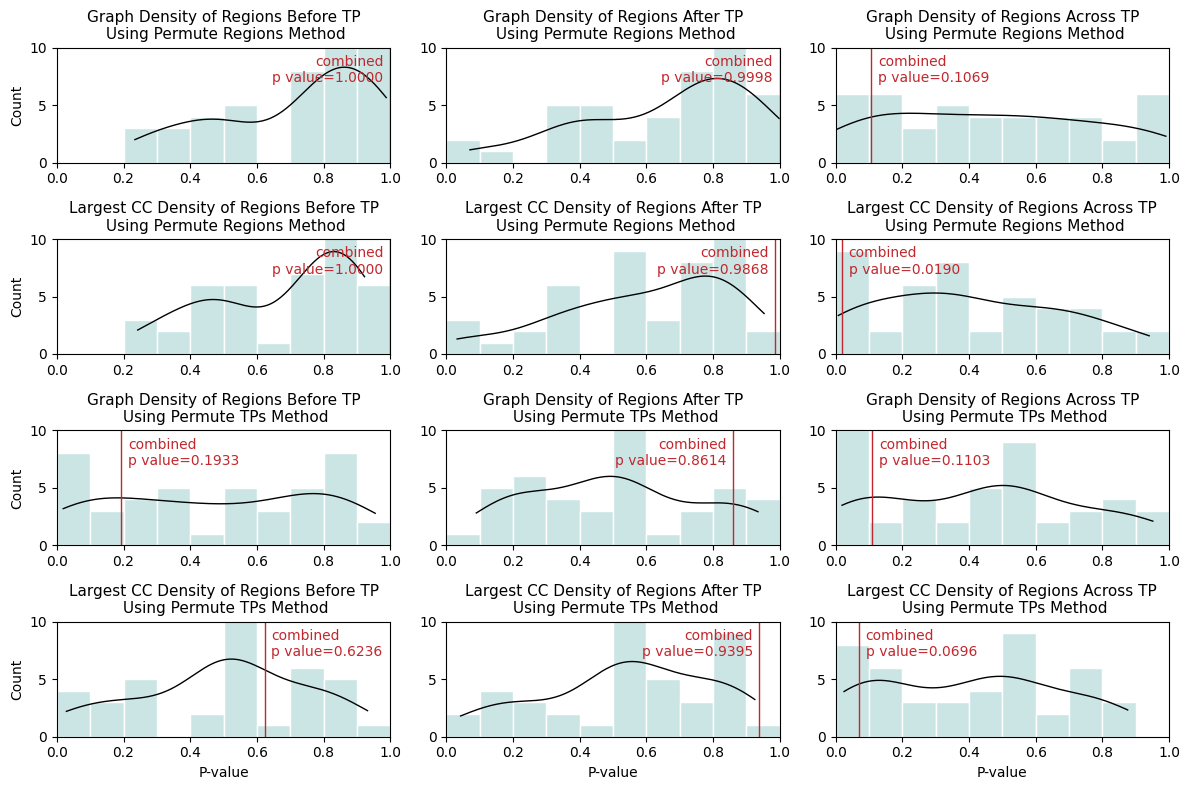

In [89]:
list1 = ['pr', 'pt']
list2 = ['gd', 'lcc']
list3 = ['BTP', 'ATP', 'ACTP']
combinations = itertools.product(list1, list2, list3)
category_list = ['_'.join(combination) for combination in combinations]

plt.figure(figsize=(12, 8))
axes = []
for i, category in enumerate(category_list):
    ax = plt.subplot(4, 3, i+1)
    axes.append(ax)
    show_density_p_value_subplot(p_value_df, category)


axes[0].set_ylabel('Count')
axes[3].set_ylabel('Count')
axes[6].set_ylabel('Count')
axes[9].set_ylabel('Count')
axes[9].set_xlabel('P-value')
axes[10].set_xlabel('P-value')
axes[11].set_xlabel('P-value')

plt.tight_layout()

plt.savefig('figures/P-value_density.png', dpi=300)
plt.savefig('figures/P-value_density.svg')

plt.show()

# Density difference

In [90]:
def show_dif_subplot(df, category, id):
    category_list = category.split('_')
    permute_type = category_list[0]
    connection_type = category_list[1]
    figure_type = category_list[2]
    df_permute = df[(df['permute_type'] == permute_type) & (df['connection_type'] == connection_type) & (df['id'] == id)] 
    df_permute = df_permute[figure_type]
    df_actual = df[(df['permute_type'] == 'ac') & (df['connection_type'] == connection_type) & (df['id'] == id)]
    patient_id = df_actual['patient_id'].values[0]
    df_actual = df_actual[figure_type].values[0]
    p_value = calculate_p_value(df_permute, df_actual)
    # sns.kdeplot(df_permute, fill=False)
    ax = sns.histplot(data=df_permute, bins=5, kde=True, binrange=[0, 1], 
                 color='#7899bc',
                #  alpha=1,
                 line_kws={'color': 'k', 'linewidth': 1},
                 edgecolor='white')
    if len(set(df_permute)) != 1:
        ax.lines[0].set_color('k')
    
    plt.axvline(x=df_permute.mean(), color='blue', linewidth = 1)
    if df_permute.mean()<0.7:
        plt.text(df_permute.mean()+0.02, 550, f'avg = {df_permute.mean():.2f}', color='blue', ha='left')
    else:
        plt.text(df_permute.mean()-0.02, 550, f'avg = {df_permute.mean():.2f}', color='blue', ha='right')

    plt.axvline(x=df_actual, color='#c1272d', linestyle='--', linewidth = 1)
    if df_actual<0.7:
        plt.text(df_actual+0.02, 280, f'actual = {df_actual:.2f}\np={p_value}', color='#c1272d', ha='left')
    else:
        plt.text(df_actual-0.02, 280, f'actual = {df_actual:.2f}\np={p_value}', color='#c1272d', ha='right')
    
    plt.text(-1+0.02, 700, f'Seizure {id}\n{patient_id}', color='k', ha='left', fontweight='bold')

    # sns.rugplot(data=df_permute, height=.1)
    dict1 = {'gd':'Graph Density', 'lcc':'Largest CC Density', 'pr':'Permute Regions', 'pt':'Permute TPs',
              'BTP-ATP':'Regions Before TP and After TP', 'BTP-ACTP':'Regions Before TP and Across TP', 'ATP-ACTP':'Regions After TP and Across TP'}
    plt.title(f'{dict1[connection_type]} Difference between\n{dict1[figure_type]}\nUsing {dict1[permute_type]} Method', fontsize=10)
    plt.xlim([-1, 1])
    plt.ylim([0, 1000])
    plt.yticks([i for i in range(0, 1001, 250)])
    plt.xlabel("")
    plt.ylabel("")

['pr_gd_BTP-ATP', 'pr_gd_BTP-ACTP', 'pr_gd_ATP-ACTP', 'pr_lcc_BTP-ATP', 'pr_lcc_BTP-ACTP', 'pr_lcc_ATP-ACTP', 'pt_gd_BTP-ATP', 'pt_gd_BTP-ACTP', 'pt_gd_ATP-ACTP', 'pt_lcc_BTP-ATP', 'pt_lcc_BTP-ACTP', 'pt_lcc_ATP-ACTP']


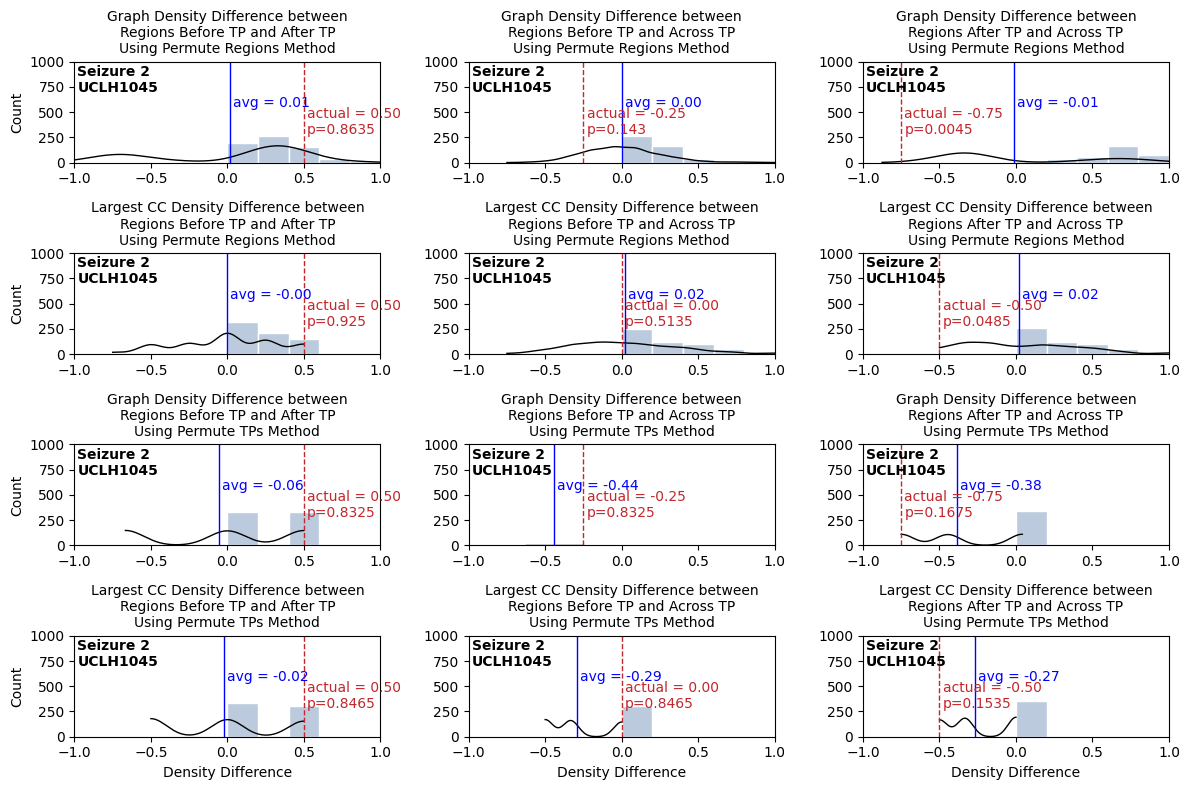

In [91]:
list1 = ['pr', 'pt']
list2 = ['gd', 'lcc']
list3 = ['BTP-ATP', 'BTP-ACTP', 'ATP-ACTP']
combinations = itertools.product(list1, list2, list3)
category_list = ['_'.join(combination) for combination in combinations]

print(category_list)
plt.figure(figsize=(12, 8))
axes = []
for i, category in enumerate(category_list):
    ax = plt.subplot(4, 3, i+1)
    axes.append(ax)
    show_dif_subplot(df, category, id)

axes[0].set_ylabel('Count')
axes[3].set_ylabel('Count')
axes[6].set_ylabel('Count')
axes[9].set_ylabel('Count')
axes[9].set_xlabel('Density Difference')
axes[10].set_xlabel('Density Difference')
axes[11].set_xlabel('Density Difference')

plt.tight_layout()

plt.savefig(f'figures/seizure{id}_difference.png', dpi=300)
plt.savefig(f'figures/seizure{id}_difference.svg')

plt.show()

In [92]:
def save_dif_p_values(df):
    sample_size = set(df['id'])
    print(f'sample_size: {len(sample_size)}')

    list1 = ['pr', 'pt']
    list2 = ['gd', 'lcc']
    list3 = ['BTP-ATP', 'BTP-ACTP', 'ATP-ACTP']

    data = []
    
    for id in sample_size:
        for permute_type in list1:
            for connection_type in list2:
                df1 = df[(df['permute_type'] == permute_type) & (df['connection_type'] == connection_type) & (df['id'] == id)]
                df2 = df[(df['permute_type'] == 'ac') & (df['connection_type'] == connection_type) & (df['id'] == id)]
                regions_result = []
                for region_type in list3:
                    sample = df1[region_type]
                    actual = df2[region_type].values[0]
                    p_value = calculate_p_value(sample, actual)
                    regions_result.append(p_value)
                patient = df2['patient_id'].values[0]
                row = {
                    'id' : id,
                    'patient_id' : patient,
                    'permute_type' : permute_type, 
                    'connection_type' : connection_type, 
                    'BTP-ATP' : regions_result[0], 
                    'BTP-ACTP' : regions_result[1], 
                    'ATP-ACTP' : regions_result[2]
                }
                data.append(row)

    p_value_result = pd.DataFrame(data, columns=['id','patient_id', 'permute_type', 'connection_type', 'BTP-ATP', 'BTP-ACTP', 'ATP-ACTP'])

    return p_value_result

In [93]:
p_value_df = save_dif_p_values(df)
print(p_value_df.head())
print(p_value_df.shape)

output_path = os.path.join('output_data', 'difference_p_value_results.csv')
p_value_df.to_csv(output_path, index=False)
print(f'DataFrame saved to {output_path}')

sample_size: 44
   id patient_id permute_type connection_type  BTP-ATP  BTP-ACTP  ATP-ACTP
0   1   UCLH1005           pr              gd   0.1260    0.4750    0.8610
1   1   UCLH1005           pr             lcc   0.0465    0.4250    0.8310
2   1   UCLH1005           pt              gd   0.1085    0.0305    0.6855
3   1   UCLH1005           pt             lcc   0.0330    0.0940    0.9340
4   2   UCLH1045           pr              gd   0.8635    0.1430    0.0045
(176, 7)
DataFrame saved to output_data\difference_p_value_results.csv


In [94]:
def combine_p_values(p_values_list):
    # epsilon = 1e-10
    epsilon = 1/(1000 * 2)
    p_values_list = np.array(p_values_list)
    count0 = len(p_values_list) - np.count_nonzero(p_values_list)
    p_values_list[p_values_list == 0] = epsilon

    chi_squared_stat = -2 * np.sum(np.log(p_values_list))
    combined_p_value = chi2.sf(chi_squared_stat, 2 * len(p_values_list))
    return combined_p_value, count0



def show_p_value_subplot(df, category, if_sort=False):
    category_list = category.split('_')
    permute_type = category_list[0]
    connection_type = category_list[1]
    figure_type = category_list[2]
    df_permute = df[(df['permute_type'] == permute_type) & (df['connection_type'] == connection_type)] 
    df_permute = df_permute[figure_type]

    sns.histplot(df_permute, binrange=[0, 1], bins=10, kde=True,
                 color='#99cccc',
                #  alpha=1,
                 line_kws={'color': 'k', 'linewidth': 1},
                 edgecolor='white')
    if len(set(df_permute)) != 1:
        ax.lines[0].set_color('k')

    plt.xlim([0, 1])
    plt.ylim([0, 10])
    plt.yticks([i for i in range(0, 11, 5)])
    plt.xlabel("")
    plt.ylabel("")
    
    combined_p_value, count0 = combine_p_values(df_permute)
    print(f'combined p value: {combined_p_value}, number of 0: {count0}')

    plt.axvline(x=combined_p_value, color='#c1272d', linewidth = 1)
    if combined_p_value<0.7:
        plt.text(combined_p_value+0.02, 7, f'combined\np value={combined_p_value:.4f}', color='#c1272d', ha='left')
    else:
        plt.text(combined_p_value-0.02, 7, f'combined\np value={combined_p_value:.4f}', color='#c1272d', ha='right')
    
    dict1 = {'gd':'Graph Density', 'lcc':'Largest CC Density', 'pr':'Permute Regions', 'pt':'Permute TPs',
              'BTP-ATP':'Regions Before TP and After TP', 'BTP-ACTP':'Regions Before TP and Across TP', 'ATP-ACTP':'Regions After TP and Across TP'}
    plt.title(f'{dict1[connection_type]} Difference between\n{dict1[figure_type]}\nUsing {dict1[permute_type]} Method', fontsize=10)

combined p value: 0.9767288598069691, number of 0: 0
combined p value: 0.9999964402548551, number of 0: 0
combined p value: 0.9879331999789297, number of 0: 0
combined p value: 0.9861489007366672, number of 0: 0
combined p value: 0.9999990523511264, number of 0: 0
combined p value: 0.9741268452296625, number of 0: 0
combined p value: 0.5889643637679359, number of 0: 0
combined p value: 0.5785299847537814, number of 0: 0
combined p value: 0.7907251340026542, number of 0: 0
combined p value: 0.1856095328824925, number of 0: 0
combined p value: 0.698778272560649, number of 0: 0
combined p value: 0.9865996468176773, number of 0: 0


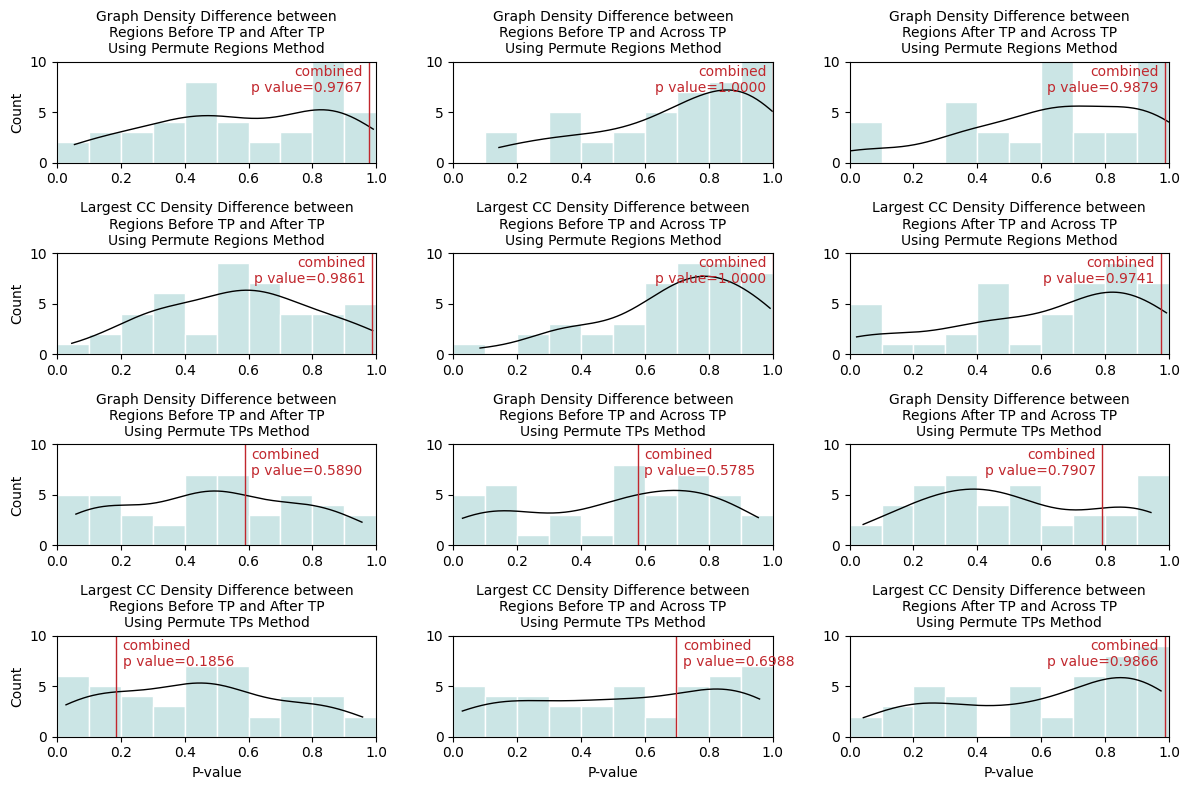

In [95]:
list1 = ['pr', 'pt']
list2 = ['gd', 'lcc']
list3 = ['BTP-ATP', 'BTP-ACTP', 'ATP-ACTP']
combinations = itertools.product(list1, list2, list3)
category_list = ['_'.join(combination) for combination in combinations]

plt.figure(figsize=(12, 8))
axes = []
for i, category in enumerate(category_list):
    ax = plt.subplot(4, 3, i+1)
    axes.append(ax)
    show_p_value_subplot(p_value_df, category)


axes[0].set_ylabel('Count')
axes[3].set_ylabel('Count')
axes[6].set_ylabel('Count')
axes[9].set_ylabel('Count')
axes[9].set_xlabel('P-value')
axes[10].set_xlabel('P-value')
axes[11].set_xlabel('P-value')

plt.tight_layout()

plt.savefig('figures/P-value_difference.png', dpi=300)
plt.savefig('figures/P-value_difference.svg')

plt.show()
